In [247]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
import torch
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch import sqrt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display

In [248]:
width = 256
height = 256
max_baseline = 4.0
nant = 24
center_position=[128,128]
nant=4

In [249]:
sky_im, sky, new_uv, baselines, masked_uv, outofmask = baselines_and_indicies_ect(param)

In [250]:
def baselines_and_indicies_ect(param):

    ant_pos=param.reshape(nant,2)

    width=256
    center_position=[128,128]
    max_baseline=4.0

    # Calculate baselines
    baseline_array = []
    for i in range(nant):
        for j in range(nant):
            if i != j:
                a1 = ant_pos[i]
                a2 = ant_pos[j]
                u = a1[0] - a2[0]
                v = a1[1] - a2[1]
                baseline_array.append([u, v])

    baselines = torch.tensor(baseline_array)

    sky = torch.zeros((width, height), dtype=torch.complex64, requires_grad=False)
    sky[width // 2, height // 2] = 1

    sky_brightness = torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(sky)))


    uv = torch.zeros((width, width), dtype=torch.complex64, requires_grad=False)

    for u, v in baselines:
        u_index = int((u + max_baseline) * width / (2 * max_baseline))
        v_index = int((v + max_baseline) * width / (2 * max_baseline))
        if 0 <= u_index < width and 0 <= v_index < width:
            uv[u_index, v_index] = sky_brightness[v_index, u_index]


    sky_im=torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(new_uv)))

    mask = torch.zeros((width, width), dtype=torch.complex64, requires_grad=False )
    cy, cx = center_position
    y, x = torch.meshgrid(torch.arange(width), torch.arange(width))
    mask = (x - cx)**2 + (y - cy)**2 <= 2**2

    masked_uv = sky_im * mask
    outofmask=sky_im-masked_uv
    


    return sky_im, sky, new_uv, baselines, masked_uv, outofmask

In [251]:
def loss_func(masked_uv,outofmask, module=torch):
    
    loss = (module.abs(masked_uv).sum())**2/(module.abs((outofmask)).sum() + module.abs(masked_uv).sum())**2

    return loss

In [252]:

steps = 500

loss_history = []

ant_array = []
for i in range(nant):
    xx = torch.rand(1).item() * max_baseline
    yy = torch.rand(1).item() * max_baseline
    ant_array.append([xx, yy])

    ant_pos = torch.tensor(ant_array)
    param = ant_pos.flatten()

optimizer = optim.SGD([param], lr=1, momentum=1)


for step in range(steps):

    sky_im, sky, new_uv, baselines_tensor, masked_uv, outofmask = baselines_and_indicies_ect(param)    

    #loss = (torch.abs(masked_uv).sum())**2/(torch.abs((outofmask)).sum()+torch.abs(masked_uv).sum())**2
    #-(torch.abs(outofmask))
    #nt_ratio=(np.abs(np.sum(np.abs(outofmask.detach().numpy()))))/(np.abs(np.sum(np.abs(masked_uv.detach().numpy()))))

    Loss=loss_func(masked_uv , outofmask, module=torch)
    Loss.grad_fn
    optimizer.zero_grad()

    loss= Variable(Loss, requires_grad = True)
    loss.grad_fn
    #Compute gradients
    loss.backward()
    
    # Update parameters
    optimizer.step()

    loss_history.append(loss.item())

    if step % 100 == 0:
        print(f'Step {step}: loss_history = {loss.item()}') 



Step 0: loss_history = 6.584735245951379e-08
Step 100: loss_history = 6.584735245951379e-08
Step 200: loss_history = 6.584735245951379e-08
Step 300: loss_history = 6.584735245951379e-08
Step 400: loss_history = 6.584735245951379e-08


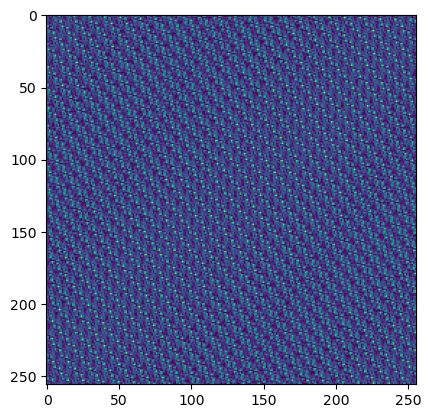

In [253]:
making_sky_im=(np.abs(sky_im.detach().numpy()))
plt.imshow(making_sky_im)
plt.show()

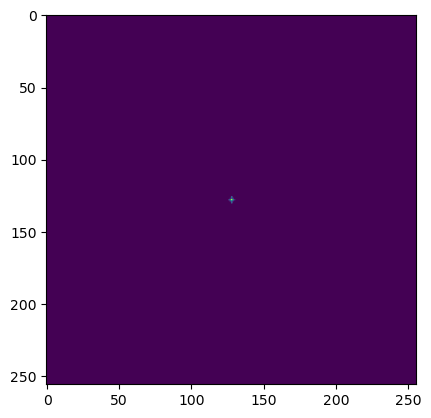

In [254]:
making_sky_im_2=(np.abs(masked_uv.detach().numpy()))
plt.imshow(making_sky_im_2)
plt.show()

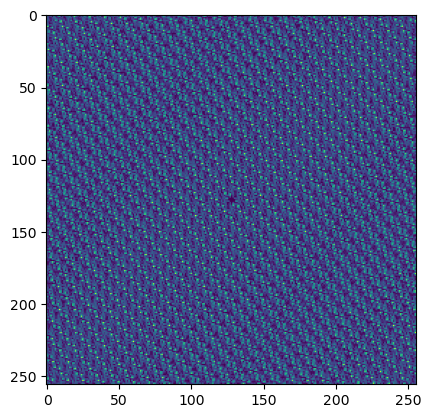

In [255]:
making_sky_im_3=(np.abs(outofmask.detach().numpy()))
plt.imshow(making_sky_im_3)
plt.show()

In [265]:
loop = 1000
ratio = []

best_ratio = float('-inf')  # Initialize with a very low value
best_params = None

for _ in range(loop):  # Use _ since loop variable is not used inside
    ant_array = []
    for i in range(nant):
        xx = torch.rand(1).item() * max_baseline
        yy = torch.rand(1).item() * max_baseline
        ant_array.append([xx, yy])

    ant_pos = torch.tensor(ant_array)
    params = ant_pos.flatten()

    sky_im, sky, new_uv, baselines, masked_uv, outofmask = baselines_and_indicies_ect(params)
    
    nt_ratio = loss_func(masked_uv, outofmask, module=np)
    ratio.append(nt_ratio)

    if nt_ratio > best_ratio:
        best_ratio = nt_ratio
        best_params = params

# Now, best_ratio holds the highest ratio and best_params holds the corresponding parameters


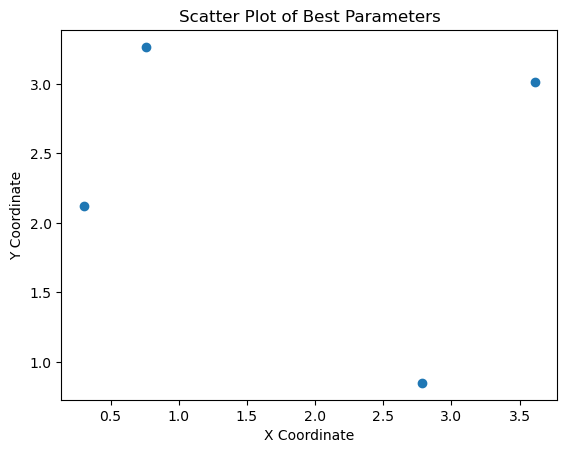

In [270]:
import torch
import matplotlib.pyplot as plt

# Assuming best_params is a 1D tensor with shape (2 * nant,)
nant = len(best_params) // 2
a = best_params.reshape(nant, 2)

# Extract x and y coordinates
x_coords = a[:, 0].numpy()
y_coords = a[:, 1].numpy()

# Create the scatter plot
plt.scatter(x_coords, y_coords)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Best Parameters')
plt.show()



In [273]:
loop=1000
ratio=[]

for loop in range(loop):

    ant_array = []
    for i in range(nant):
        xx = torch.rand(1).item() * max_baseline
        yy = torch.rand(1).item() * max_baseline
        ant_array.append([xx, yy])

    ant_pos = torch.tensor(ant_array)
    params = ant_pos.flatten()

    sky_im, sky, new_uv, baselines, masked_uv, outofmask = baselines_and_indicies_ect(params)
    
    nt_ratio=loss_func(masked_uv,outofmask, module=np)
    #np.abs(np.sum(np.abs(outofmask.detach().numpy()))))/(np.abs(np.sum(np.abs(masked_uv.detach().numpy()))))
    
    ratio.append(nt_ratio)

    

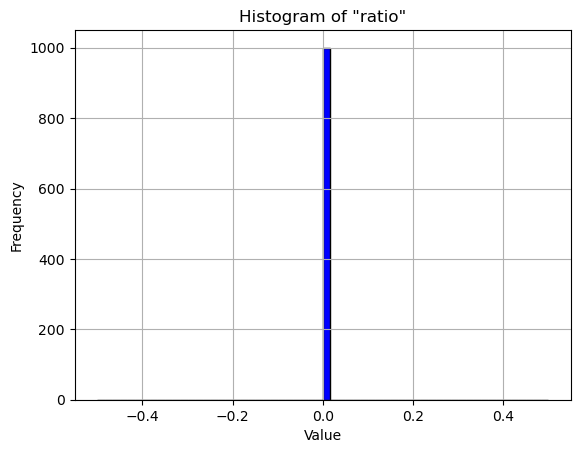

In [274]:
plt.hist(ratio, bins=60, color='blue', edgecolor='black')
plt.title('Histogram of "ratio"')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("ratio_test_20000its_60bins.png")
plt.show()



In [261]:
#plt.plot(x0.detach().numpy(), y0.detach().numpy(), 'o', color='red',label="Initial Positions")
#plt.plot(x1.detach().numpy(), y1.detach().numpy(), 'o', color='red')
#plt.plot(x2.detach().numpy(), y2.detach().numpy(), 'o', color='red')
#plt.plot(x3.detach().numpy(), y3.detach().numpy(), 'o', color='red')
#plt.savefig(".pdf")

#print("Init Coords")
#print(x0.detach().numpy(),y0.detach().numpy())
#print(x2.detach().numpy(),y2.detach().numpy())
#print(x1.detach().numpy(),y1.detach().numpy())
#print(x3.detach().numpy(),y3.detach().numpy())

In [286]:
loop = 50000
ratio = []


worst_ratio = float('inf')  # Initialize with a very low value
worst_params = None

best_ratio = float('-inf')  # Initialize with a very low value
best_params = None

for _ in range(loop):  # Use _ since loop variable is not used inside
    ant_array = []
    for i in range(nant):
        xx = torch.rand(1).item() * max_baseline
        yy = torch.rand(1).item() * max_baseline
        ant_array.append([xx, yy])

    ant_pos = torch.tensor(ant_array)
    params = ant_pos.flatten()

    sky_im, sky, new_uv, baselines, masked_uv, outofmask = baselines_and_indicies_ect(params)
    
    nt_ratio = loss_func(masked_uv, outofmask, module=np)
    ratio.append(nt_ratio)

    if nt_ratio < worst_ratio:
        worst_ratio = nt_ratio
        worst_params = params

    if nt_ratio > best_ratio:
        best_ratio = nt_ratio
        best_params = params
# Now, best_ratio holds the highest ratio and best_params holds the corresponding parameters


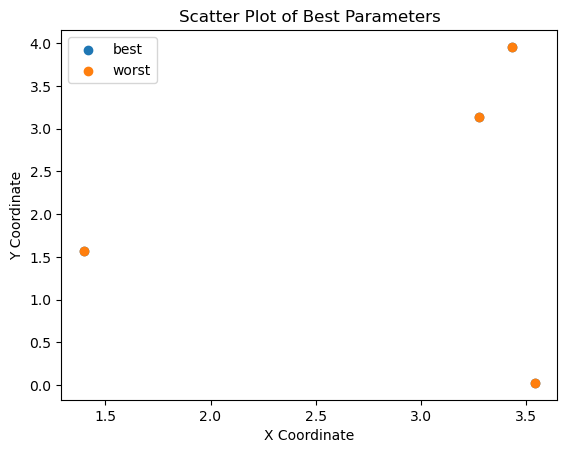

In [278]:
# Assuming best_params is a 1D tensor with shape (2 * nant,)
nant = len(best_params) // 2
a = best_params.reshape(nant, 2)
b = worst_params.reshape(nant, 2)

# Extract x and y coordinates
x_coords = a[:, 0].numpy()
y_coords = a[:, 1].numpy()

x_coords_b = b[:, 0].numpy()
y_coords_b = b[:, 1].numpy()

# Create the scatter plot
plt.scatter(x_coords, y_coords, label='best')
plt.scatter(x_coords_b, y_coords_b,label='worst')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot of Best Parameters')
plt.legend()
plt.show()

In [284]:
b_sky_im, sky, new_uv, baselines, masked_uv, outofmask = baselines_and_indicies_ect(best_params)

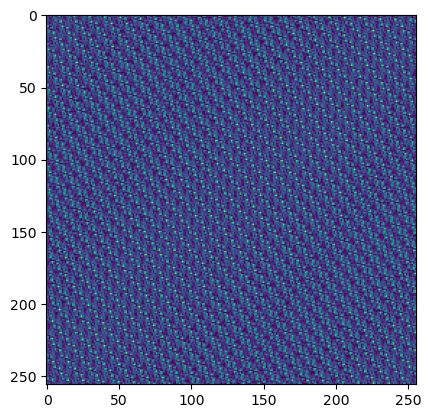

In [285]:
making_sky_im=(np.abs(b_sky_im.detach().numpy()))
plt.imshow(making_sky_im)
plt.show()